In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Inhomogeneous Network with Brian2

Implementation of an inhomogeneous network of 10,000 neurons (8,000 excitatory and 2,000 inhibitory) with 2% random connectivity using parameters from Vogels et al. (2011).

In [ ]:
# Network parameters
N_exc = 8000  # Number of excitatory neurons
N_inh = 2000  # Number of inhibitory neurons
N_total = N_exc + N_inh  # Total number of neurons
connectivity_prob = 0.02  # 2% random connectivity

# Neuron model parameters (Leaky Integrate-and-Fire)
tau_m = 20*ms  # Membrane time constant
V_rest = -60*mV  # Resting potential
V_reset = -60*mV  # Reset potential after spike
V_thresh = -50*mV  # Spike threshold
tau_refrac = 5*ms  # Refractory period

# Synaptic parameters (conductance-based, from Vogels et al. 2011)
V_E = 0*mV  # Excitatory reversal potential
V_I = -80*mV  # Inhibitory reversal potential
tau_E = 5*ms  # Excitatory synaptic time constant
tau_I = 10*ms  # Inhibitory synaptic time constant
g_basic = 3*nS  # Basic weight unit
g_exc = g_basic  # Excitatory synaptic conductance (3 nS)
gamma = 10  # Scaling factor for inhibitory weights
g_inh = gamma * g_basic  # Inhibitory synaptic conductance (30 nS)
g_leak = 10*nS  # Leak conductance (for proper scaling)

# Background input
I_b = 200*pA  # Background current to all neurons


In [ ]:
# Clear any previous Brian2 objects
start_scope()

# Define the conductance-based neuron model
# Standard LIF with conductance-based synapses and background current
eqs = '''
dv/dt = ((V_rest - v) + (g_e / g_leak) * (V_E - v) + (g_i / g_leak) * (V_I - v) + I_b / g_leak) / tau_m : volt (unless refractory)
dg_e/dt = -g_e / tau_E : siemens 
dg_i/dt = -g_i / tau_I : siemens
'''ij

# Create a single unified neuron group
all_neurons = NeuronGroup(N_total, eqs,
                         threshold='v > V_thresh',
                         reset='v = V_reset',
                         refractory=tau_refrac,
                         method='euler')

# set everything to resting state
all_neurons.v = V_rest
all_neurons.g_e = 0*nS
all_neurons.g_i = 0*nS

# Create subgroups for excitatory and inhibitory neurons
exc_neurons = all_neurons[:N_exc]
inh_neurons = all_neurons[N_exc:]

print(f"Created unified network with {N_total} neurons")


Created unified network with 10000 neurons
  - Excitatory: 8000 neurons (indices 0-7999)
  - Inhibitory: 2000 neurons (indices 8000-9999)
Using conductance-based synapses (Vogels et al. 2011)


In [10]:
# Create synaptic connections with 2% random connectivity
# increment the correct conductances 
synapses = Synapses(all_neurons, all_neurons,
                   model='w : siemens',
                   on_pre='''g_e_post += w * int(i < N_exc)
                            g_i_post += w * int(i >= N_exc)
                         ''')
synapses.connect(p=connectivity_prob)

# Set conductances based on presynaptic neuron type
# Excitatory connections (EE, EI)
synapses.w['i < N_exc'] = g_exc
# Inhibitory connections (IE, II)
synapses.w['i >= N_exc'] = g_inh

print(f"Total synapses: {len(synapses)}")
print(f"Excitatory synapses: {np.sum(synapses.i[:] < N_exc)}")
print(f"Inhibitory synapses: {np.sum(synapses.i[:] >= N_exc)}")


WARNING    'i' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 49. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Total synapses: 2000971
Excitatory synapses: 1601152
Inhibitory synapses: 399819


In [5]:
# Add monitors for activity tracking
spike_mon = SpikeMonitor(all_neurons)
rate_mon = PopulationRateMonitor(all_neurons)

print("Network setup complete")


Network setup complete


In [6]:
# Run simulation
run(5*second)
print(f"Simulation complete")
print(f"Total spikes: {spike_mon.num_spikes}")
print(f"Average firing rate: {spike_mon.num_spikes / N_total / second:.2f} Hz")

Simulation complete
Total spikes: 527862
Average firing rate: 52.79 Hz


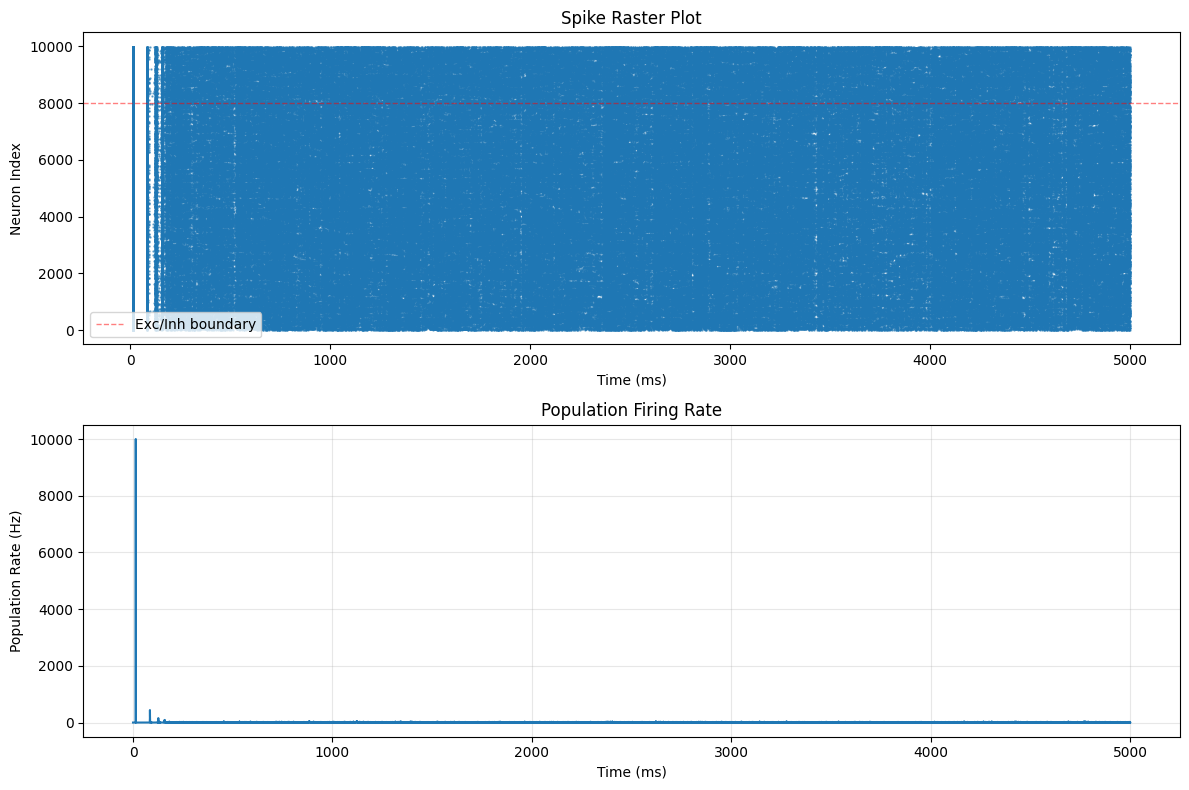

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raster plot
ax1.scatter(spike_mon.t/ms, spike_mon.i, s=0.5, alpha=0.6)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Neuron Index')
ax1.set_title('Spike Raster Plot')
ax1.axhline(N_exc, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Exc/Inh boundary')
ax1.legend()

# Population rate
ax2.plot(rate_mon.t/ms, rate_mon.rate/Hz, linewidth=1.5)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Population Rate (Hz)')
ax2.set_title('Population Firing Rate')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()